In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parthplc/medical-image-dataset")

print("Path to dataset files:", path)

100%|██████████████████████████████████████| 13.0M/13.0M [00:04<00:00, 2.89MB/s]

Extracting files...


Path to dataset files: /Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1


In [6]:
import numpy as np
import pandas as pd
import os

dataset_path = "/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1"

# Iterate over all files in the dataset directory
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset/63.jpg
/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset/77.jpg
/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset/88.jpg
/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset/89.jpg
/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset/76.jpg
/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset/62.jpg
/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset/74.jpg
/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset/60.jpg
/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset/48.jpg
/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versio

In [7]:
dataset_path = "/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset"

# Get a sorted list of training images
train_images = sorted(os.listdir(dataset_path))

print("Total images:", len(train_images))
print("First 5 images:", train_images[:5])  # Print the first 5 image names


Total images: 120
First 5 images: ['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg']


In [8]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# Define dataset path
dataset_path = "/Users/himanshujha/.cache/kagglehub/datasets/parthplc/medical-image-dataset/versions/1/Dataset"

# Get sorted list of images
train_images = sorted(os.listdir(dataset_path))

# Initialize an empty list to store processed images
train_image = []

# Loop through each image, load it, and preprocess
for im in train_images:
    img_path = os.path.join(dataset_path, im)
    
    # Load image in grayscale mode and resize
    img = image.load_img(img_path, target_size=(64, 64), color_mode='grayscale')
    
    # Convert image to array
    img = image.img_to_array(img)
    
    # Normalize pixel values to range [0, 1]
    img = img / 255.0  
    
    # Append to list
    train_image.append(img)

# Convert list to NumPy array
train_df = np.array(train_image)

print("Shape of dataset:", train_df.shape)  # (num_samples, 64, 64, 1)


Shape of dataset: (120, 64, 64, 1)


In [23]:
import matplotlib.pyplot as plt

def show_img(dataset):
    f, ax = plt.subplots(1, 5)  # Create 1 row, 5 columns
    f.set_size_inches(40, 20)  # Adjust figure size
    
    for i in range(5):  # Fix indexing issue (i runs from 0 to 4)
        ax[i].imshow(dataset[i+5].reshape(64, 64), cmap='gray')  # Shift index
        # Hide axes for better visualization

    plt.show()




In [14]:
import numpy as np

def add_noise(image):
    # Ensure image has correct shape (64, 64, 1) for grayscale
    if len(image.shape) == 2:  # If shape is (64, 64), add a channel dimension
        image = image.reshape(image.shape[0], image.shape[1], 1)

    row, col, ch = image.shape
    mean = 0
    sigma = 1  # Standard deviation
    gauss = np.random.normal(mean, sigma, (row, col, ch))  # Generate Gaussian noise
    
    noisy = image + gauss * 0.07  # Scale noise intensity
    noisy = np.clip(noisy, 0, 1)  # Clip values to keep them in valid range [0, 1]
    
    return noisy


In [17]:
noisy_image = add_noise(train_df[0])  # Apply noise to the first image
print(noisy_image.shape)

(64, 64, 1)


In [20]:
noised_df = []

for img in train_df:
    noisy = add_noise(img)  # Fix function name
    noised_df.append(noisy)

# Convert list to NumPy array
noised_df = np.array(noised_df)

print("Shape of noised dataset:", noised_df.shape)  # Should match train_df.shape


Shape of noised dataset: (120, 64, 64, 1)


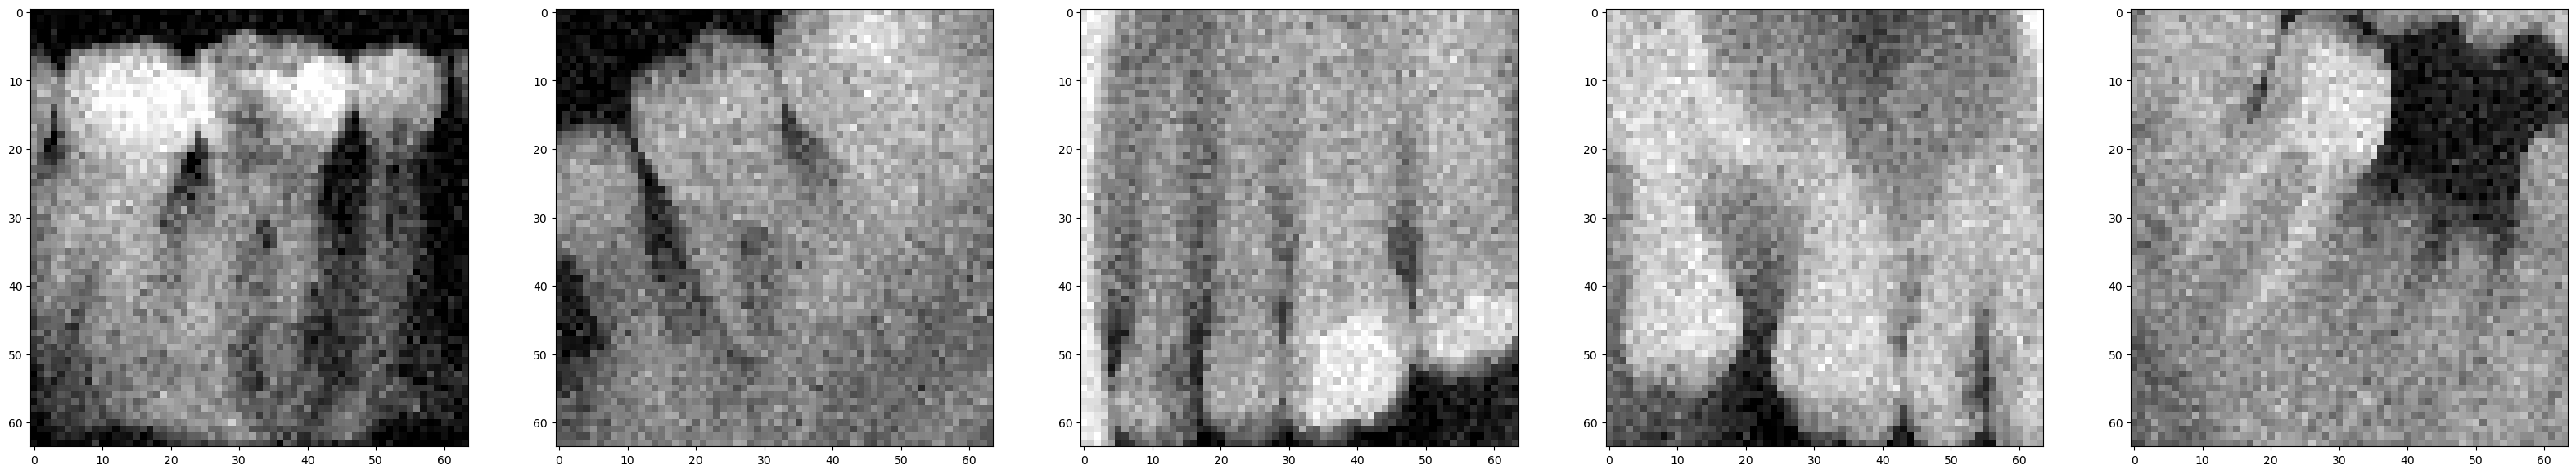

In [22]:
show_img(noised_df)

In [34]:
xclean = train_df[0:100]
xclean_test = train_df[100:]
xnoised= noised_df[0:100]
xtest= noised_df[100:]

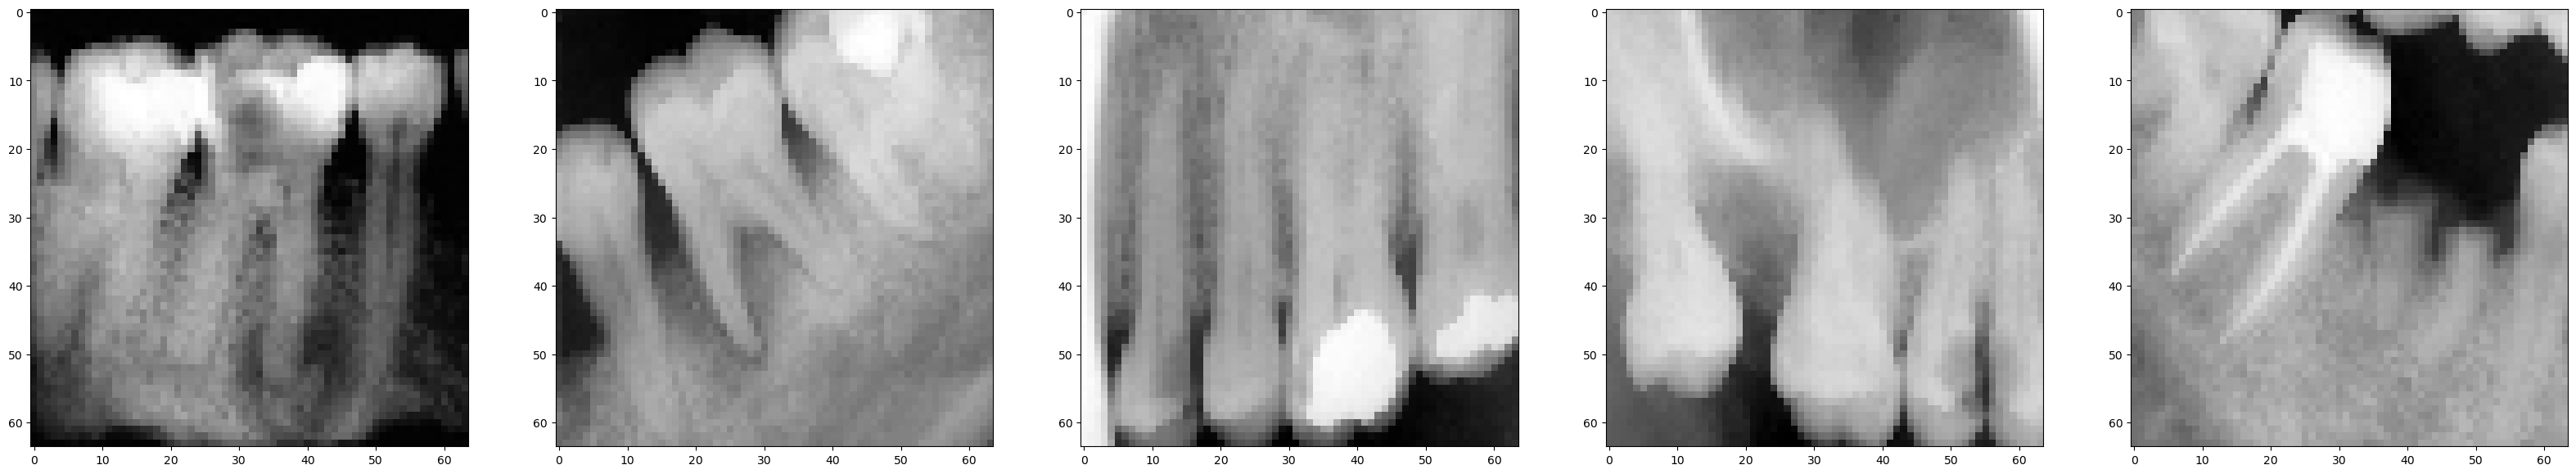

In [38]:
show_img(xclean)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Convolutional Block
def ConvBlock(x, filters):
    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    return x

# Upsampling Block
def UpConv(x, skip, filters):
    x = layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])  # Skip connection
    x = ConvBlock(x, filters)
    
    return x

# U-Net Model
def UNet(input_shape=(64, 64, 1), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    e1 = ConvBlock(inputs, 64)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(e1)

    e2 = ConvBlock(p1, 128)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(e2)

    e3 = ConvBlock(p2, 256)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(e3)

    e4 = ConvBlock(p3, 512)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(e4)

    e5 = ConvBlock(p4, 1024)  # Bottleneck

    # Decoder
    d1 = UpConv(e5, e4, 512)
    d2 = UpConv(d1, e3, 256)
    d3 = UpConv(d2, e2, 128)
    d4 = UpConv(d3, e1, 64)

    # Output layer
    outputs = layers.Conv2D(num_classes, kernel_size=1, activation="sigmoid")(d4)

    return Model(inputs, outputs)

# Instantiate the model
model = UNet(input_shape=(64, 64, 1), num_classes=1)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ re_lu_19[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    147,584 │ re_lu_20[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ re_lu_21[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_23[0][0] 

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping


In [39]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import os

# Disable GPU usage
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Forces TensorFlow to ignore the GPU

# Verify CPU is being used
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("Running on:", tf.config.experimental.list_physical_devices('CPU'))

# Compile the model for denoising
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Use 'mae' if you prefer absolute error
    metrics=['mae']  # Monitor Mean Absolute Error as an additional metric
)

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

# Train the model on CPU
history = model.fit(
    xnoised, xclean,  # X = Noisy images, Y = Clean images
    epochs=40,
    batch_size=10,
    validation_data=(xtest, xclean_test),  # Use clean validation images
    callbacks=[early_stopping]
)


Num GPUs Available: 0
Running on: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 981ms/step - loss: 0.0147 - mae: 0.0848 - val_loss: 0.0658 - val_mae: 0.2114
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 966ms/step - loss: 0.0036 - mae: 0.0447 - val_loss: 0.1456 - val_mae: 0.3303
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 924ms/step - loss: 0.0027 - mae: 0.0392 - val_loss: 0.0839 - val_mae: 0.2404
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 954ms/step - loss: 0.0022 - mae: 0.0358 - val_loss: 0.0950 - val_mae: 0.2616
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 970ms/step - loss: 0.0025 - mae: 0.0386 - val_loss: 0.0563 - val_mae: 0.1901
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 981ms/step - loss: 0.0022 - mae: 0.0362 - val_loss: 0.0545 - val_mae: 0.1873
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 993ms/step - loss: 0.0021 - mae: 0.0359 - val_loss: 0.0558 - val_mae: 0.1911
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0019 - m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


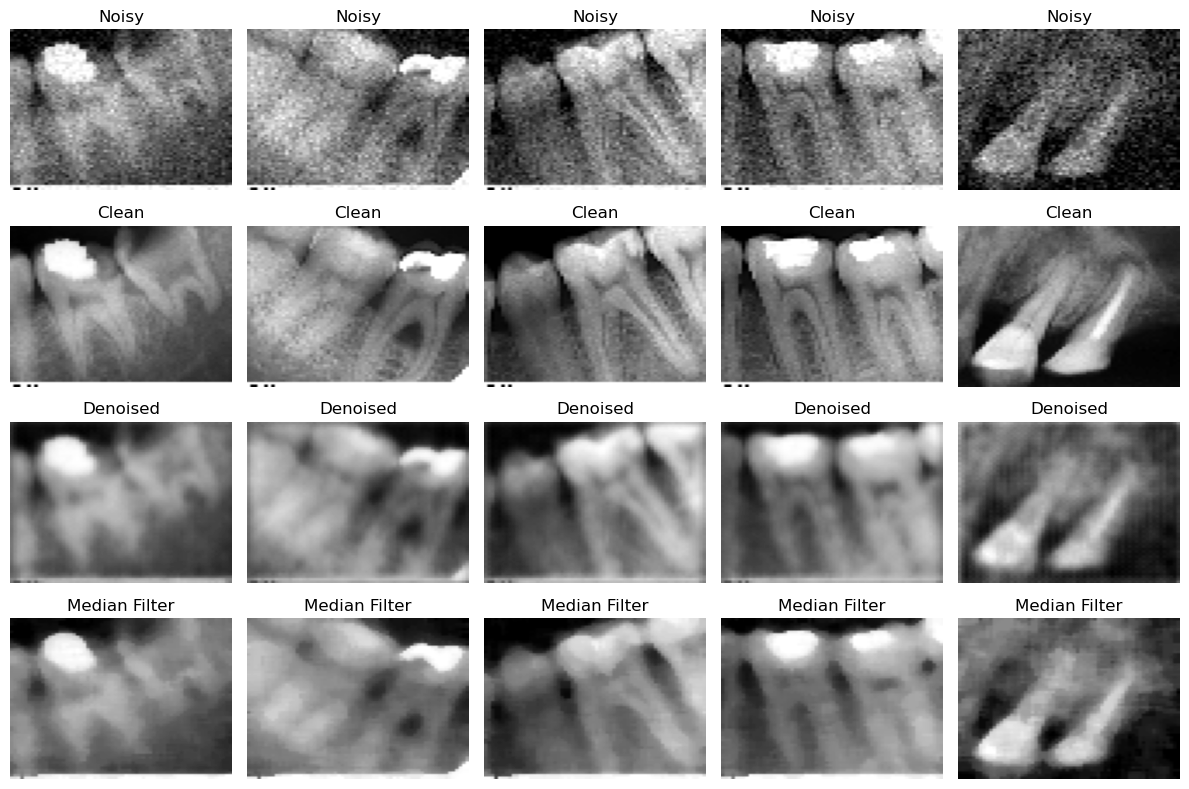

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions
pred = model.predict(xtest[:5])

def plot_predictions(y_true, y_pred, x_noised):
    f, ax = plt.subplots(4, 5, figsize=(12, 8))

    for i in range(5):
        # Noisy Input
        ax[0, i].imshow(x_noised[i].squeeze(), aspect='auto', cmap='gray')
        ax[0, i].set_title("Noisy")
        ax[0, i].axis("off")

        # Ground Truth (Clean Image)
        ax[1, i].imshow(y_true[i].squeeze(), aspect='auto', cmap='gray')
        ax[1, i].set_title("Clean")
        ax[1, i].axis("off")

        # Model Prediction (Denoised Output)
        ax[2, i].imshow(y_pred[i].squeeze(), aspect='auto', cmap='gray')
        ax[2, i].set_title("Denoised")
        ax[2, i].axis("off")

        # Median Filtering on Noisy Image (for comparison)
        median_filtered = cv2.medianBlur((x_noised[i].squeeze() * 255).astype(np.uint8), 5)
        ax[3, i].imshow(median_filtered, aspect='auto', cmap='gray')
        ax[3, i].set_title("Median Filter")
        ax[3, i].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function with correct inputs
plot_predictions(xclean_test[:5], pred[:5], xtest[:5])


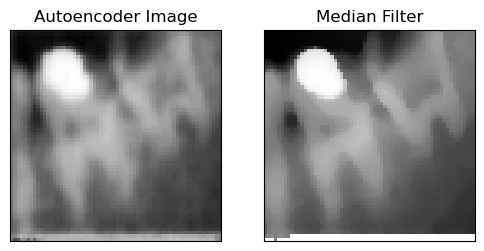

In [57]:
new_image = cv2.medianBlur(xclean_test[0], (5))
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(pred[0].reshape(64,64), cmap='gray')
plt.title('Autoencoder Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(new_image, cmap='gray')
plt.title('Median Filter')
plt.xticks([])
plt.yticks([])
plt.show()

In [58]:
from math import log10, sqrt 
  
def PSNR(original, denoiced): 
    mse = np.mean((original - denoiced) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  
value1 = PSNR(xtest[0], new_image)
value2 = PSNR(xtest[0], pred[0])

print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

PSNR value for Denoised image is 64.52217308727198 dB while for Median filtered image is 58.57551164430488 dB
